# Basic Training Scheme development notebook

## Importing section

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset
from etnn.data.tree_structure import TreeNode
from etnn.nn.layer_framework import ChiralLayerManagementFramework
from tqdm import tqdm
import matplotlib.pyplot as plt
from etnn.tools.training import train_epoch, eval_epoch, EpochControl, ConfigStore, AccuracyManager

In [2]:
import numpy as np

## Parameter definition

In [3]:
NUM_GONDOLAS = 10
NUM_PART_PG = 5
DATASET_SIZE = 10_000
DATASET_PATH = "../datasets"

In [4]:
val_perc = 0.1
test_perc = 0.2

In [5]:
SAVING_PATH = "."
MODEL_SAVING_NAME = "model.pt"

In [6]:
CONFIG_SAVING_NAME = "config.json"
ACCURACY_SAVING_NAME = "accuracies.csv"
RESULTS_FOLDER = "."

In [7]:
# todo: take care of None values as representing not yet implemented features
config = ConfigStore(
    in_dim=15,
    hidden_dim=32,
    out_dim=1,
    k=2,
    is_accuracy_score=False,
    which_score=None,
    loss_name=None,
    optimizer_name=None,
    num_max_epochs=20,
    learning_rate=0.001,
    batch_size=32,
    early_stop_tol=5,
    is_classification=False
)

## data preparation

In [8]:
dataset = load_pure_ferris_wheel_dataset(
    num_gondolas=NUM_GONDOLAS,
    num_part_pg=NUM_PART_PG,
    num_to_generate=DATASET_SIZE,
    dataset_path=DATASET_PATH
)

In [9]:
len(dataset)

10000

In [10]:
generator = torch.Generator().manual_seed(420)
train_ds, val_ds, test_ds = random_split(
    dataset,
    [1-val_perc-test_perc, val_perc, test_perc],
    generator=generator
)

In [11]:
train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False)

In [12]:
# todo: add more tree mutated sequences that are in dataset
# todo: add some faulty sequences which disturb this and see how much this affects the training

## Build tree structure

In [13]:
tree_structure = TreeNode(
    node_type="C",
    children=[
        TreeNode("P", [TreeNode("E", NUM_PART_PG)])
        for _ in range(NUM_GONDOLAS)
    ]
)

## Define device

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
device

'cuda'

## Define Model

In [16]:
model = ChiralLayerManagementFramework(
    in_dim=config.in_dim,
    tree=tree_structure,
    hidden_dim=config.hidden_dim,
    out_dim=config.out_dim,
    k=config.k
).to(device)

## Define Loss and Optimizers

In [17]:
criterion = nn.MSELoss()

In [18]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)

## Training

In [19]:
# init loss history
loss_history_train = []
loss_history_test = []

In [20]:
epoch_control = EpochControl(
    model_save_name=MODEL_SAVING_NAME,
    config_save_name=CONFIG_SAVING_NAME,
    saving_folder_path=SAVING_PATH,
    tolerance=config.early_stop_tol,
    is_accuracy_score=config.is_accuracy_score
)

In [23]:
accuracy_protocoller = AccuracyManager(
    storage_name=ACCURACY_SAVING_NAME,
    storage_path=RESULTS_FOLDER,
    is_classification=False
)

In [21]:
# train for N epochs
for epoch in tqdm(range(config.num_max_epochs)):
    mean_train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        criterion
    )

    loss_history_train += [mean_train_loss]

    mean_test_loss = eval_epoch(
        model,
        test_loader,
        device,
        criterion
    )
    loss_history_test += [mean_test_loss]

    # check if model is better and save it
    if epoch_control.retain_best_and_stop(model, mean_train_loss, mean_test_loss, config):
        break

  5%|▌         | 1/20 [00:06<02:06,  6.64s/it]

++save++


 10%|█         | 2/20 [00:12<01:54,  6.36s/it]

++save++


 40%|████      | 8/20 [00:47<01:09,  5.80s/it]

++save++


 65%|██████▌   | 13/20 [01:22<00:44,  6.33s/it]


In [22]:
loss_history_train

[tensor(1106.1125),
 tensor(39.5074),
 tensor(39.3588),
 tensor(38.4557),
 tensor(39.8104),
 tensor(41.8749),
 tensor(39.6666),
 tensor(39.0974),
 tensor(39.9636),
 tensor(38.8876),
 tensor(38.8336),
 tensor(40.4734),
 tensor(40.4052),
 tensor(38.8379)]

In [23]:
loss_history_test

[tensor(38.0051),
 tensor(35.2167),
 tensor(35.2580),
 tensor(37.9280),
 tensor(35.4004),
 tensor(35.5691),
 tensor(38.0398),
 tensor(35.1602),
 tensor(35.2702),
 tensor(35.3108),
 tensor(45.8615),
 tensor(35.5662),
 tensor(35.9774),
 tensor(37.1072)]

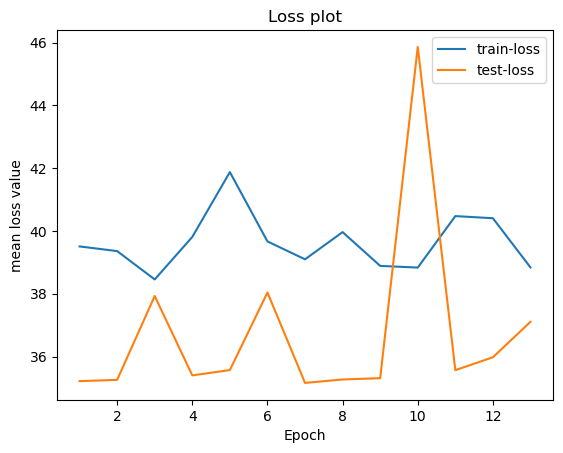

In [24]:
plt.figure()
idx = np.arange(len(loss_history_train))
offset = 1
plt.plot(idx[offset:], loss_history_train[offset:], label="train-loss")
plt.plot(idx[offset:], loss_history_test[offset:], label="test-loss")
plt.title("Loss plot")
plt.xlabel("Epoch")
plt.ylabel("mean loss value")
plt.legend()
plt.show()

In [25]:
test_loss = torch.nn.CrossEntropyLoss()

In [26]:
label = torch.tensor([0., 1.,2.,3.,4.])
pred = torch.tensor([1.1, 1., 2., 2., 4.])

In [27]:
test_loss(pred, label)

tensor(16.1880)

todo:
- build option for classification instead of regression
- either still predict number or make softmax classification

## Test/Debug

with open("test1.txt", "w") as file:
    file.write("config_id, epoch\n")
    file.write("0,1")

with open("test1.txt", "a") as file:
    file.write(f"\n")

import pandas as pd

pd.read_csv("test1.txt")

for x,y in train_loader:
    break

x.shape

x

y.shape

y

for i in range(1000):
    optimizer.zero_grad()
    prediction = model(x).flatten()
    loss = criterion(prediction, y)
    print(f"Epoch:{i+1} - loss:{loss}")
    loss.backward()
    optimizer.step()

y

model(x).flatten()